In [27]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

plt.rc('font', family='Malgun Gothic')  # 폰트 지정
plt.rc('axes', unicode_minus=False)  # 마이너스 폰트 설정
%config InlineBackend.figure_format = 'retina'  # 그래프 글씨 뚜렷

In [28]:
df_train = pd.read_csv("../data/df_train_004.csv")
df_test = pd.read_csv("../data/df_test_004.csv")

df_train['target'] = df_train['사망자수']*10 + df_train['중상자수'] * \
    5 + df_train['경상자수']*3 + df_train['부상자수']
df_train.drop(columns=['사망자수', '중상자수', '경상자수', '부상자수'], axis=1, inplace=True)

In [29]:
X = df_train.drop(columns='target', axis=1)
X = X + 1
X = np.log1p(X)
y = df_train['target']

In [30]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# CatBoostRegressor

In [31]:
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

In [32]:
# CatBoostRegressor 모델 생성 및 RMSLE 메트릭 및 손실 함수 설정
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.005,
    loss_function='RMSE',  # You can use 'RMSE' as a built-in loss function
    custom_metric=['MSLE'],  # RMSLE as a custom metric
    random_state=42
)

In [33]:
# 모델 훈련 및 RMSLE 메트릭 설정
model.fit(x_train, y_train, eval_set=(x_test, y_test), early_stopping_rounds=10,plot=True, verbose_eval=50)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3.1773084	test: 3.2748486	best: 3.2748486 (0)	total: 4.41ms	remaining: 4.41s
50:	learn: 3.1614232	test: 3.2600575	best: 3.2600575 (50)	total: 208ms	remaining: 3.86s
100:	learn: 3.1509827	test: 3.2505703	best: 3.2505703 (100)	total: 411ms	remaining: 3.66s
150:	learn: 3.1437811	test: 3.2444209	best: 3.2444209 (150)	total: 625ms	remaining: 3.52s
200:	learn: 3.1386849	test: 3.2402510	best: 3.2402510 (200)	total: 891ms	remaining: 3.54s
250:	learn: 3.1347211	test: 3.2373811	best: 3.2373811 (250)	total: 1.16s	remaining: 3.46s
300:	learn: 3.1314335	test: 3.2353433	best: 3.2353433 (300)	total: 1.43s	remaining: 3.31s
350:	learn: 3.1288732	test: 3.2338407	best: 3.2338407 (350)	total: 1.7s	remaining: 3.13s
400:	learn: 3.1266776	test: 3.2327984	best: 3.2327984 (400)	total: 1.97s	remaining: 2.95s
450:	learn: 3.1245500	test: 3.2319324	best: 3.2319324 (450)	total: 2.24s	remaining: 2.73s
500:	learn: 3.1225291	test: 3.2312190	best: 3.2312190 (500)	total: 2.51s	remaining: 2.5s
550:	learn: 3.120

In [34]:
msle_score = model.get_best_score()['learn']['MSLE']
print(f'MSLE on validation set: {msle_score}')

MSLE on validation set: 0.20866875772119411


In [35]:
msle_score = model.get_best_score()['validation']['MSLE']
print(f'MSLE on validation set: {msle_score}')

MSLE on validation set: 0.20916840677021353


In [36]:
y_pred = model.predict(X)

In [37]:
y_round = np.round(y_pred)
y_floor = np.floor(y_pred)
y_ceil = np.ceil(y_pred)

In [38]:
print(f'Training MSE: {mean_squared_error(y, y_pred)}')
print(f'Training MSE: {mean_squared_error(y, y_round)}')
print(f'Training MSE: {mean_squared_error(y, y_floor)}')
print(f'Training MSE: {mean_squared_error(y, y_ceil)}')

Training MSE: 9.896189609461679
Training MSE: 10.006009949243706
Training MSE: 10.33249160374738
Training MSE: 10.09014923865559


In [39]:
# 특성 중요도 가져오기
feature_importance = model.get_feature_importance(type='FeatureImportance')

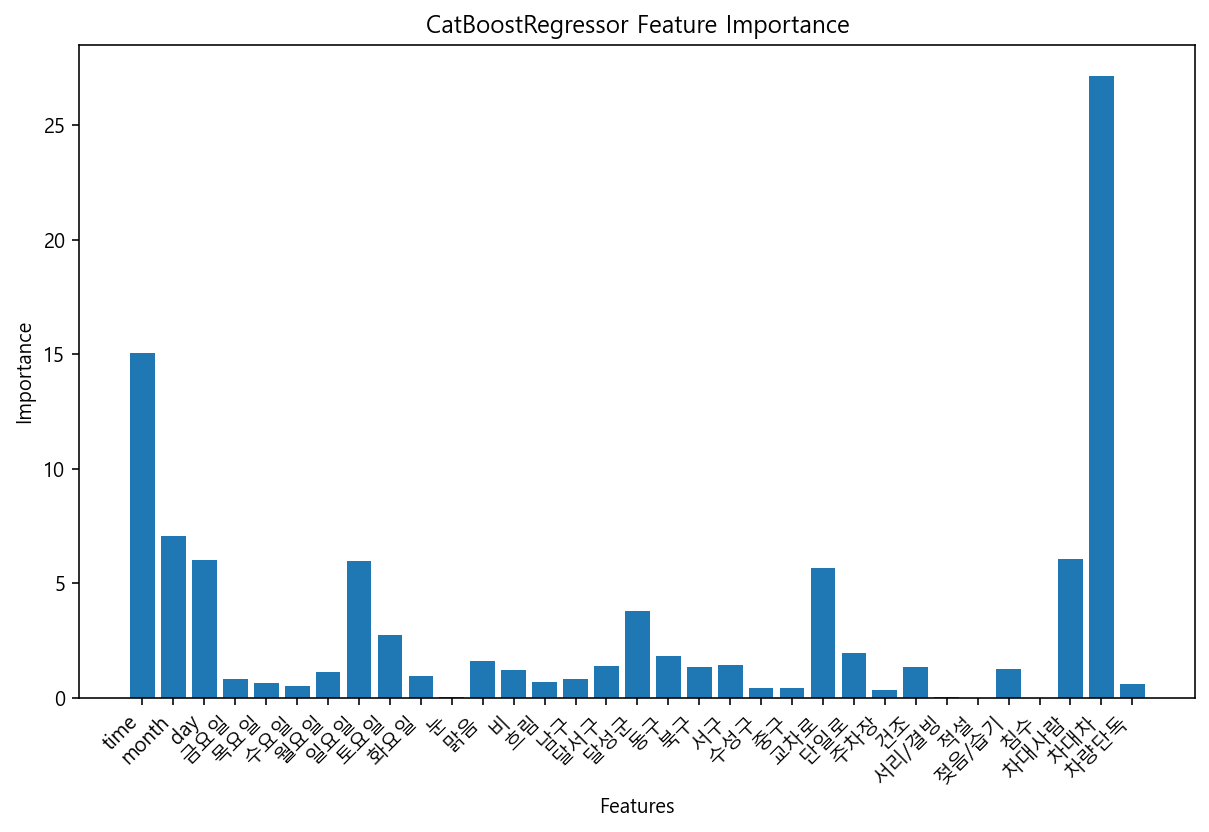

In [40]:
# 특성 중요도를 데이터프레임으로 변환 (옵션)
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('CatBoostRegressor Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.show()

In [41]:
sub_file = pd.read_csv("../data/sample_submission.csv")

In [42]:
sub_file['ECLO'] = np.round(model.predict(df_test))

In [43]:
sub_file.ECLO.value_counts()

5.0    8136
4.0    2369
6.0     444
3.0      14
Name: ECLO, dtype: int64

In [44]:
sub_file.to_csv("../data/sub_file/014_catboost.csv", index=False)